In [1]:
import pandas as pd
import numpy as np
import openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [3]:
bfr = pd.read_excel(raw_dir /'BfR.xlsx')

In [4]:
bfr.shape

(72, 12)

In [6]:
bfr.columns

Index(['INPUT', 'FOUND_BY', 'DTXSID', 'PREFERRED_NAME', 'CASRN', 'SMILES',
       'Name', 'CAS number', 'SMILES.1', 'EU Classification',
       'EU Classification Num', 'Unnamed: 11'],
      dtype='object')

In [124]:
bfr = (bfr
 .rename(columns=lambda x: x.replace(" ", "_"))
 .dropna(subset = ['SMILES'])
 .filter(['DTXSID', 'SMILES', 'CASRN', 'PREFERRED_NAME', 'EU_Classification',	'EU_Classification_Num'])
 .drop_duplicates(subset = ['DTXSID'], keep = 'first')
 
 )

In [125]:
bfr['SMILES'].info()

<class 'pandas.core.series.Series'>
Index: 69 entries, 0 to 71
Series name: SMILES
Non-Null Count  Dtype 
--------------  ----- 
69 non-null     object
dtypes: object(1)
memory usage: 1.1+ KB


In [126]:
bfr.to_csv(raw_dir/'bfr_cleaned.csv')

In [205]:
irritants = (bfr
 .query('EU_Classification_Num == 38')
 .DTXSID.tolist()
)

In [128]:
non_irritants = (bfr
 .query('EU_Classification_Num != 38')
 .DTXSID.tolist()
)

In [129]:
print(f'number of non-irritants is {len(non_irritants)} and number of irritants is {len(irritants)}')

number of non-irritants is 43 and number of irritants is 26


In [130]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import grakel
import networkx as nx

MOLS = dict(zip(bfr['DTXSID'], bfr['SMILES']))
MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
MOLS = {i:j for i,j in MOLS.items() if j}
FP0 = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,2048)) for i in MOLS.values()])
FP0.index = MOLS.keys()
FP0.columns = ['mrgn_%d'%i for i in FP0.columns]

In [131]:
from scipy.spatial.distance import pdist, squareform

In [132]:
D_mgrn = pd.DataFrame(squareform(pdist(FP0, 'jaccard')), columns = FP0.index, index = FP0.index)

In [133]:
S_mgrn = 1-D_mgrn

In [134]:
#S_mgrn.loc[irritants, irritants]

<Axes: >

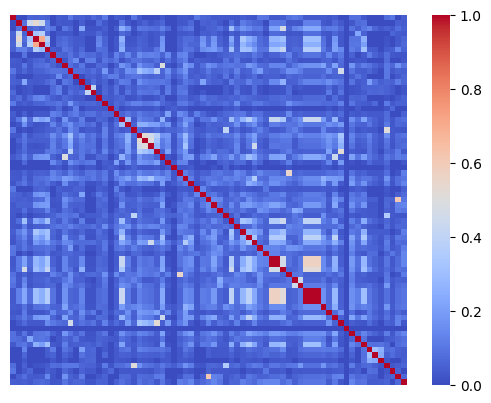

In [135]:
sns.heatmap(S_mgrn, cmap = 'coolwarm',xticklabels=False, yticklabels=False)

In [136]:
def transform_matrix(df):
    a = df.where(np.triu(np.ones(df.shape)).astype('bool'))
    a = df.stack().reset_index()
    a = a.where(a.iloc[:,0] != a.iloc[:,1])
    a = a.dropna()
    a.columns = ['target', 'source', 'jaccard']
    a = a.sort_values(by = 'jaccard', ascending = False)
    a['bins'] = pd.cut(x = a['jaccard'], bins = [-0.000001,0.1,0.3, 0.5,0.7,1])
    return a, a['bins'].value_counts(dropna = False, normalize = True)

In [216]:
test = transform_matrix(p1)

In [217]:
test[1]

bins
(-1e-06, 0.1]    0.498721
(0.1, 0.3]       0.328218
(0.3, 0.5]       0.098465
(0.5, 0.7]       0.051151
(0.7, 1.0]       0.023444
Name: proportion, dtype: float64

In [214]:
irritants2 = irritants.copy()
irritants2.remove('DTXSID8047395')

In [215]:
transform_matrix(S_txp.loc[irritants2, irritants2])[1]

bins
(-1e-06, 0.1]    0.590000
(0.1, 0.3]       0.266667
(0.3, 0.5]       0.130000
(0.7, 1.0]       0.010000
(0.5, 0.7]       0.003333
Name: proportion, dtype: float64

In [218]:
transform_matrix(p1.loc[irritants, irritants])[1]

bins
(0.1, 0.3]       0.390769
(-1e-06, 0.1]    0.378462
(0.3, 0.5]       0.116923
(0.5, 0.7]       0.076923
(0.7, 1.0]       0.036923
Name: proportion, dtype: float64

## ToxPrints

In [182]:
txps = pd.read_excel(raw_dir/'bfr_toxprints.xlsx')

In [183]:
txps.columns

Index(['INPUT', 'FOUND_BY', 'DTXSID', 'PREFERRED_NAME',
       'atom:element_main_group', 'atom:element_metal_group_I_II',
       'atom:element_metal_group_III', 'atom:element_metal_metalloid',
       'atom:element_metal_poor_metal', 'atom:element_metal_transistion_metal',
       ...
       'ring:polycycle_bicyclo_propene', 'ring:polycycle_spiro_[2.2]pentane',
       'ring:polycycle_spiro_[2.5]octane', 'ring:polycycle_spiro_[4.5]decane',
       'ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane',
       'ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene',
       'ring:polycycle_tricyclo_[3.7.7]bullvalene',
       'ring:polycycle_tricyclo_[3.7.7]semibullvalene',
       'ring:polycycle_tricyclo_adamantane',
       'ring:polycycle_tricyclo_benzvalene'],
      dtype='object', length=733)

In [184]:
S_txp = (txps
         .drop_duplicates(subset = ['DTXSID'], keep = 'first')
 .set_index('DTXSID')
 .drop(['INPUT', 'FOUND_BY', 'PREFERRED_NAME'], axis = 1)
.dropna(how = 'any')
 .pipe(lambda df : 1- pd.DataFrame(squareform(pdist(df, 'jaccard')), columns = df.index, index = df.index))
 .rename_axis(index=None, columns=None) 
)

In [185]:
S_txp.shape

(67, 67)

<Axes: >

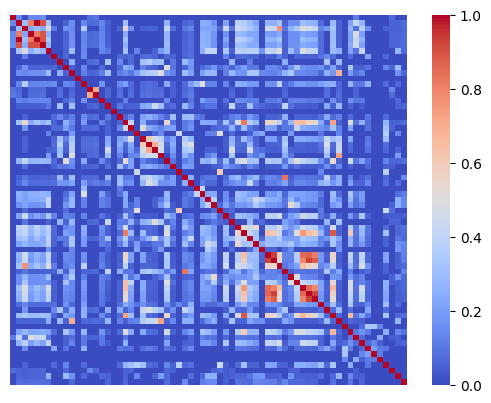

In [143]:
sns.heatmap(S_txp,cmap = 'coolwarm',xticklabels=False, yticklabels=False)

In [144]:
stat_txp = transform_matrix(S_txp)

In [146]:
stat_txp[1]

bins
(-1e-06, 0.1]    0.642243
(0.1, 0.3]       0.245590
(0.3, 0.5]       0.086386
(0.5, 0.7]       0.014925
(0.7, 1.0]       0.010855
Name: proportion, dtype: float64

In [45]:
stat_wl= transform_matrix(p1)
stat_wl[1]

bins
(-1e-06, 0.1]    0.498721
(0.1, 0.3]       0.328218
(0.3, 0.5]       0.098465
(0.5, 0.7]       0.051151
(0.7, 1.0]       0.023444
Name: proportion, dtype: float64

In [147]:
import grakel
import networkx as nx

In [148]:
#| echo: false
def smile_to_mol_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    g = nx.Graph()
    
    # Add nodes with atom properties
    for atom in mol.GetAtoms():
        node_label = {
    "symbol": atom.GetSymbol(),
    "degree": atom.GetDegree(),
    "hybridization": str(atom.GetHybridization()),
    "aromaticity": atom.GetIsAromatic(),
    "formal_charge": atom.GetFormalCharge(),
    "implicit_hydrogen_count": atom.GetTotalNumHs()
}
        g.add_node(atom.GetIdx(), atom_label = str(node_label))

    # Add edges with bond properties
    for bond in mol.GetBonds():
        g.add_edge(bond.GetBeginAtomIdx(), 
                   bond.GetEndAtomIdx(), 
                   bond_type=str(bond.GetBondType()))

    return g

In [151]:
graphs = {k:smile_to_mol_graph(v) for k,v in zip(bfr['DTXSID'], bfr['SMILES'])}

In [152]:
grakel_graphs = grakel.graph_from_networkx(list(graphs.values()),node_labels_tag='atom_label') 



In [153]:


# Compute the WL kernel
wl_kernel = grakel.WeisfeilerLehman(base_graph_kernel=grakel.VertexHistogram,normalize=True)
kernel_matrix = wl_kernel.fit_transform(grakel_graphs)

In [154]:
p1 = pd.DataFrame(kernel_matrix, columns = graphs.keys(), index = graphs.keys())

p1.loc[['DTXSID4044452', 'DTXSID4021929', 'DTXSID3049203'],['DTXSID4044452', 'DTXSID4021929', 'DTXSID3049203'] ]

,DTXSID4044452,DTXSID4021929,DTXSID3049203
DTXSID4044452,1.000000,0.728869,0.625000
DTXSID4021929,0.728869,1.000000,0.754594
DTXSID3049203,0.625000,0.754594,1.000000


In [155]:
S_txp.loc[['DTXSID4044452', 'DTXSID4021929', 'DTXSID3049203'],['DTXSID4044452', 'DTXSID4021929', 'DTXSID3049203'] ]

,DTXSID4044452,DTXSID4021929,DTXSID3049203
DTXSID4044452,1.0,1.0,0.9
DTXSID4021929,1.0,1.0,0.9
DTXSID3049203,0.9,0.9,1.0


In [156]:
S_mgrn.loc[['DTXSID4044452', 'DTXSID4021929', 'DTXSID3049203'],['DTXSID4044452', 'DTXSID4021929', 'DTXSID3049203'] ]

,DTXSID4044452,DTXSID4021929,DTXSID3049203
DTXSID4044452,1.000000,0.529412,0.437500
DTXSID4021929,0.529412,1.000000,0.705882
DTXSID3049203,0.437500,0.705882,1.000000


In [158]:
S_mgrn.loc[['DTXSID1024835', 'DTXSID2044769', 'DTXSID5026625', 'DTXSID1020778'],['DTXSID1024835', 'DTXSID2044769', 'DTXSID5026625', 'DTXSID1020778' ]]

,DTXSID1024835,DTXSID2044769,DTXSID5026625,DTXSID1020778
DTXSID1024835,1.000000,0.125000,0.061224,0.061224
DTXSID2044769,0.125000,1.000000,0.074074,0.074074
DTXSID5026625,0.061224,0.074074,1.000000,0.400000
DTXSID1020778,0.061224,0.074074,0.400000,1.000000


In [159]:
S_txp.loc[['DTXSID1024835', 'DTXSID2044769', 'DTXSID5026625', 'DTXSID1020778'],['DTXSID1024835', 'DTXSID2044769', 'DTXSID5026625', 'DTXSID1020778'] ]

,DTXSID1024835,DTXSID2044769,DTXSID5026625,DTXSID1020778
DTXSID1024835,1.000000,0.2,0.0,0.055556
DTXSID2044769,0.200000,1.0,0.0,0.000000
DTXSID5026625,0.000000,0.0,1.0,0.500000
DTXSID1020778,0.055556,0.0,0.5,1.000000


In [160]:
p1.loc[[ 'DTXSID1024835', 'DTXSID2044769', 'DTXSID5026625', 'DTXSID1020778'],['DTXSID1024835', 'DTXSID2044769', 'DTXSID5026625', 'DTXSID1020778'] ]

,DTXSID1024835,DTXSID2044769,DTXSID5026625,DTXSID1020778
DTXSID1024835,1.000000,0.274309,0.030492,0.033710
DTXSID2044769,0.274309,1.000000,0.131437,0.116248
DTXSID5026625,0.030492,0.131437,1.000000,0.414578
DTXSID1020778,0.033710,0.116248,0.414578,1.000000


<Axes: >

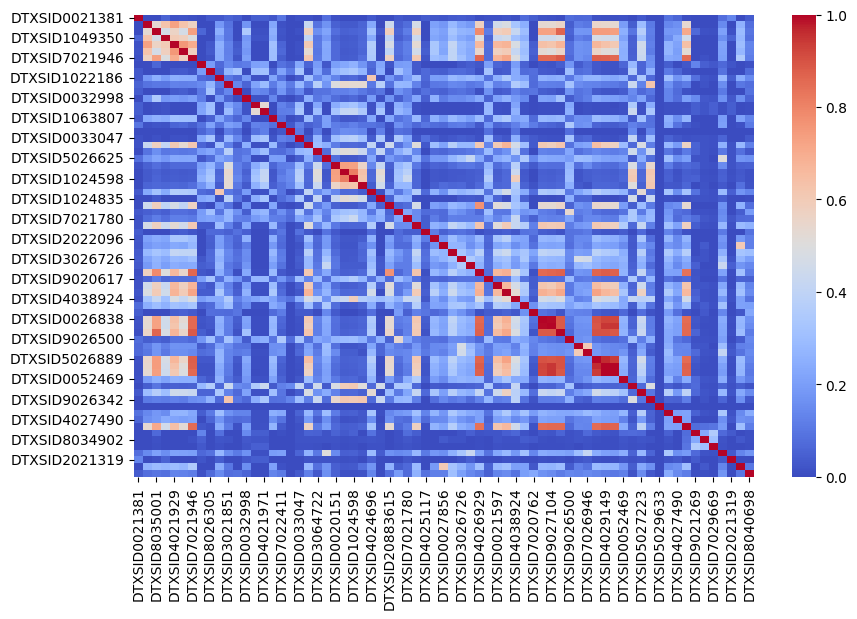

In [161]:
plt.figure(figsize = (10,6))
sns.heatmap(p1, cmap = 'coolwarm')

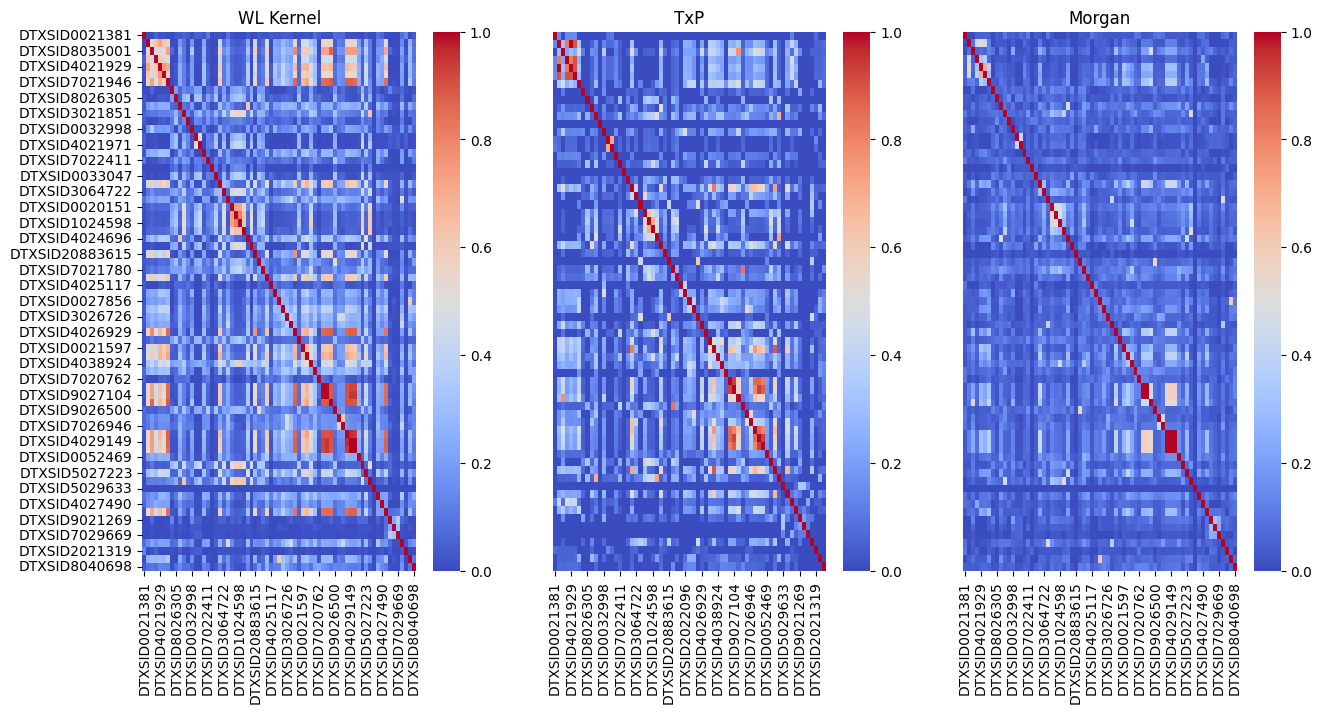

In [162]:
f, ax = plt.subplots(1,3, figsize=(15,7))
sns.heatmap(p1, cmap = 'coolwarm',  ax= ax[0])
ax[0].set_title("WL Kernel")
sns.heatmap(S_txp, cmap = 'coolwarm', ax= ax[1], yticklabels=False)
ax[1].set_title("TxP")
sns.heatmap(S_mgrn, cmap = 'coolwarm',  ax= ax[2],yticklabels=False)
ax[2].set_title("Morgan")
f.savefig(figures_dir/'bfr_sim.png', dpi = 300, bbox_inches='tight')

In [163]:
transform_matrix(p1.loc[irritants, irritants])[0]['bins'].cat.categories

IntervalIndex([(-1e-06, 0.1], (0.1, 0.3], (0.3, 0.5], (0.5, 0.7], (0.7, 1.0]], dtype='interval[float64, right]')

In [164]:
(transform_matrix(p1.loc[irritants, irritants])[0]
 
 .loc[lambda df: df["bins"] == pd.Interval(0.7, 1.0)]
 .target.unique()
)

array(['DTXSID4029149', 'DTXSID5026889', 'DTXSID7021946', 'DTXSID1026031',
       'DTXSID3049203', 'DTXSID4021929', 'DTXSID8035001'], dtype=object)

In [165]:
(bfr.where(bfr['DTXSID'].isin(['DTXSID4029149', 'DTXSID5026889', 'DTXSID7021946', 'DTXSID1026031', 'DTXSID4021929', 'DTXSID3049203', 'DTXSID8035001'])).dropna()
)

,DTXSID,SMILES,CASRN,PREFERRED_NAME,EU_Classification,EU_Classification_Num
2,DTXSID8035001,OC(=O)CCCCCCCCC=C,112-38-9,10-Undecenoic acid,R38 - MI,38.0
4,DTXSID4021929,CCCCCCBr,111-25-1,1-Bromohexane,R38 - I,38.0
5,DTXSID3049203,CCCCCBr,110-53-2,1-Bromopentane,R38 - I,38.0
6,DTXSID7021946,CCCCCCCCCCO,112-30-1,1-Decanol,R38 - I,38.0
52,DTXSID5026889,CCCCCCCCCCCC(=O)OC,111-82-0,Methyl dodecanoate,R38 - MI,38.0
53,DTXSID4029149,CCCCCCCCCCCCCCCC(=O)OC,112-39-0,Methyl hexadecanoate,R38 - I,38.0
63,DTXSID1026031,[Na+].CCCCCCCCCCCCOS([O-])(=O)=O,151-21-3,Sodium dodecyl sulfate,R38 - I,38.0


In [232]:
p1.loc['DTXSID8035001'].reset_index().sort_values(by = 'DTXSID8035001', ascending = False).head()['index'].tolist()

['DTXSID8035001',
 'DTXSID5021590',
 'DTXSID4026929',
 'DTXSID5026889',
 'DTXSID4029149']

In [236]:
(bfr.where(bfr['DTXSID'].isin(['DTXSID8035001',
 'DTXSID5021590',
 'DTXSID4026929',
 'DTXSID5026889',
 'DTXSID4029149'])
).dropna()
)

,DTXSID,SMILES,CASRN,PREFERRED_NAME,EU_Classification,EU_Classification_Num
2,DTXSID8035001,OC(=O)CCCCCCCCC=C,112-38-9,10-Undecenoic acid,R38 - MI,38.0
39,DTXSID4026929,CCCCCCCC\C=C/CCCCCCCCCCCC(N)=O,112-84-5,Erucamide,no label - NI,0.0
48,DTXSID5021590,CCCCCCCCCCCC(O)=O,143-07-7,Dodecanoic acid,no label - NI,0.0
52,DTXSID5026889,CCCCCCCCCCCC(=O)OC,111-82-0,Methyl dodecanoate,R38 - MI,38.0
53,DTXSID4029149,CCCCCCCCCCCCCCCC(=O)OC,112-39-0,Methyl hexadecanoate,R38 - I,38.0
